In [3]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

%load_ext autoreload
pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
%autoreload 2

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

find landmark files

In [6]:
data_root = Path('/mnt/Storage1/Data/K7')

landmark_files = list(data_root.glob('2020-*/Down/model=*.h5'))
landmark_files

[PosixPath('/mnt/Storage1/Data/K7/2020-08-10/Down/model=5_27_10_29_20-video=0041.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-04/Down/model=5_27_10_29_20-video=0037.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-16/Down/model=5_27_10_29_20-video=0047.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-12/Down/model=5_27_10_29_20-video=0044.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-13/Down/model=5_27_10_29_20-video=0045.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-06/Down/model=5_27_10_29_20-video=0039.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-05/Down/model=5_27_10_29_20-video=0038.h5')]

# Training the autoencoder

create and train autoencoder model

In [7]:
from simple_autoencoder import Autoencoder, PLAutoencoder
from dataloader import LandmarksDataModule
seqlen = 60
# to_drop = ['head', 'forepawR2', 'forePawL2', 'chest1', 'chest2', 'belly1', 'belly2', 'hindpawR2', 
#            'hindpawR3', 'hindpawL2', 'hindpawL3', 'tail1', 'tail2','tail3']
to_drop = ['tail1', 'tail2','tail3']
dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=3, to_drop=None, filter_by_likelihood=False)
dm.prepare_data()
n_parts = len(dm.data_frames[0].columns.levels[0])
model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 512, 10], lr=3e-4, patience=20, dropout=0.1)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=10, logger=pl.loggers.WandbLogger("landmarks autoencoder"), log_every_n_steps=1)
# trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
trainer.fit(model, dm)

wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 5 M   
/home/shuki/anaconda3/envs/deep_cluster/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/shuki/anaconda3/envs/deep_cluster/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/shuki/anaconda3/envs/deep_cluster/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [9]:
model_dir = Path('models/HG_landmarks3/')
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_dir / 'model.pt')

In [91]:
# from simple_autoencoder import Autoencoder, PLAutoencoder
# from dataloader import LandmarksDataModule
# seqlen = 60
# n_parts = 19
# dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=3)
# model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 5], lr=3e-4, seqlen=seqlen, patience=20)
# trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=30, logger=pl.loggers.WandbLogger("landmarks autoencoder"))
# trainer.fit(model, dm)

# model_dir = Path('models/04_26_2')
# os.makedirs(model_dir, exist_ok=True)
# torch.save(model.state_dict(), model_dir / 'model.pt')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 5.7 M 
--------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [12]:
from torch.utils.data import Dataset, ConcatDataset, Subset
import bisect

def find_sub_dataset(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return ds.datasets[dataset_idx], sample_idx

def find_frame(ds, idx):
    ds, idx = find_sub_dataset(ds, idx)
    if isinstance(ds, Subset):
        ds, idx = ds.dataset, ds.indices[idx]
    ds, idx = find_sub_dataset(ds, idx)
    video_file = ds.data_frame.attrs['video_file']
    frame_idxs = ds.get_indexes(idx)
    return video_file, frame_idxs


from scipy import signal as sig
energies = np.zeros(len(dm.all_ds))
for i, item in enumerate(dm.all_ds):
    item = item.reshape((dm.seqlen, -1))
    ff, Pxx = sig.periodogram(item.T, fs=dm.fps)
    energies[i] = Pxx.T[:10].mean()
    


60

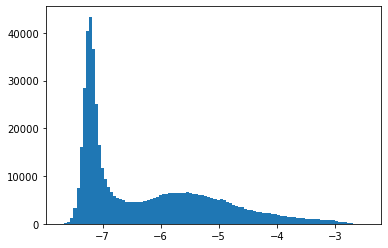

In [14]:
plt.hist(np.log10(energies), bins=100)
dm.seqlen

In [22]:
np.where(energies > 1e-3)[0][67]

46242

compare the original and reconstructed data, each plot for a different feature / coordinate

No handles with labels found to put in legend.


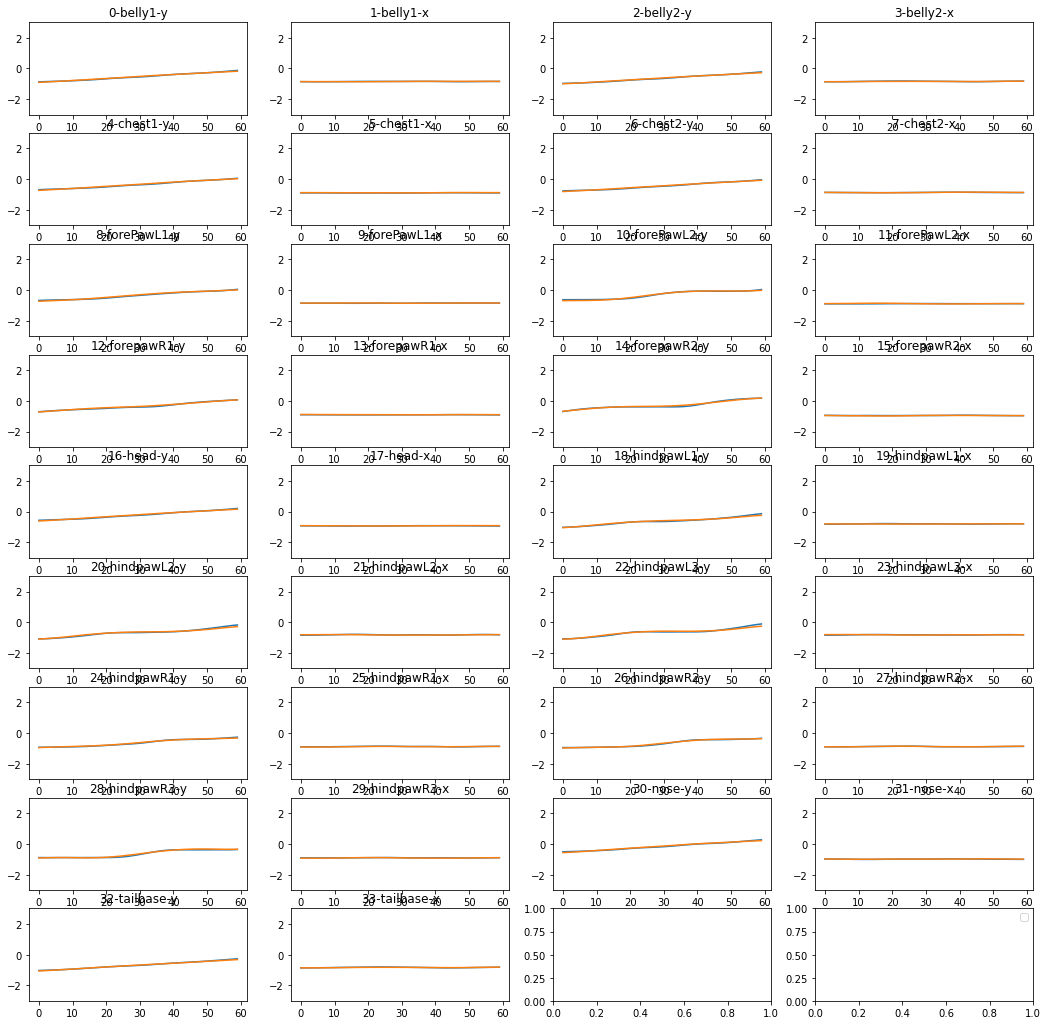

In [23]:
body_parts = dm.data_frames[0].columns.levels[0]
def compare_plot(x, y):
    x = x.reshape(-1, n_parts*2)
    y = y.reshape(-1, n_parts*2)
    fig, axes = plt.subplots(ncols=4, nrows=n_parts//2+1, figsize=(18, 18))
    for i in range(n_parts//2+1):
        for j in range(4):
            idx = 4*i + j
            if idx >= x.shape[1]: break
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            axes[i][j].set_title(f"{idx}-{body_parts[idx//2]}-{'x' if idx%2 else 'y'}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()

idx = 46242
with torch.no_grad():
    bx = torch.Tensor(dm.all_ds[idx])[None]
    out = model(bx)
compare_plot(bx[0].cpu().numpy(), out[0].cpu().numpy())

In [54]:
def find_dataset_idx(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return dataset_idx, sample_idx


ds_id, _id = find_dataset_idx(dm.all_ds, idx)
# ds, _id = find_sub_dataset(dm.all_ds.datasets[ds_id], _id)
dm.data_frames[ds_id].loc[frames].tail3

,x,y
index,,
90230,0.891732,1.991624
90231,0.892166,1.991499
90232,0.892643,1.991502
90233,0.893072,1.991606
90234,0.893322,1.991777
90235,0.893246,1.991979
90236,0.892733,1.992176
90237,0.891783,1.992341
90238,0.890578,1.992459


In [51]:
from torch.utils.data import Dataset, ConcatDataset, Subset
dm.all_ds.datasets[0].datasets[0].data_frame.attrs
import bisect

def find_sub_dataset(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return ds.datasets[dataset_idx], sample_idx

def find_frame(ds, idx):
    ds, idx = find_sub_dataset(ds, idx)
    if isinstance(ds, Subset):
        ds, idx = ds.dataset, ds.indices[idx]
    ds, idx = find_sub_dataset(ds, idx)
    video_file = ds.data_frame.attrs['video_file']
    frame_idxs = ds.get_indexes(idx)
    return video_file, frame_idxs

video_file, frames = find_frame(dm.all_ds, idx)

# Clustering the data

loading the landmark coordinates from all videos

In [13]:
# all_data = np.stack([dm.all_ds[i] for i in range(len(dm.all_ds))])
X_encoded = model.model.encode(dm.all_ds)

K = model.model.encoder[-1].out_features
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded)

1

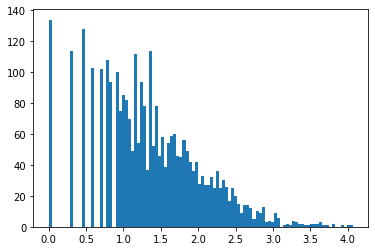

In [18]:
from collections import Counter

def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1] + seqlen//2, len(seg)] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = seqlen//2
    return sequence

segments = split_labels(labels)
plt.hist([np.log10(seg[-1]) for seg in segments], bins=100)
1

creating the dataset from all the coordinates

In [ ]:
N, n_coords, _ = coords[0].shape
all_data = [crds.reshape(-1, n_coords*2) for crds in coords]
data_lengths = [d.shape[0] - model.seqlen for d in all_data]
video_change_idxs = np.cumsum(data_lengths)[:-1]
all_data = [SequenceDataset(d, seqlen=model.seqlen, diff=model.diff, step=1) for d in all_data]
all_data = ConcatDataset(all_data)
X_encoded = model.model.encode(all_data)

In [ ]:
import pickle
with open(model_dir / 'kmeans.pkl', 'rb') as file:
#     pickle.dump(kmeans, file)
    kmeans = pickle.load(file)
    
with open(model_dir / 'kmeans.pkl', 'bb') as file:
    pickle.dump(kmeans, file)
#     kmeans = pickle.load(file)
# labels = np.load('models/11_03/labels.np.npy')

clustering the data and splitting into segments

In [ ]:
K = 30
X_encoded = model.model.encode(all_data)
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded)
'''
split the sequence of labels and returns the sequence of segments of the form:
      [(label0, segment_start0, segment_length0), ...]
for example:
44422222227777  ->  [(4, 0, 3), (2, 7), (7, 4)]
'''
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4 + model.seqlen*2, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen*2
    return sequence

labels_dict = dict(zip(landmark_files, 
                        np.split(labels, indices_or_sections=video_change_idxs)))

data_dict = dict(zip(landmark_files,
                    np.split(all_data, indices_or_sections=video_change_idxs)))

X_encoded_dict = dict(zip(landmark_files,
                         np.split(X_encoded, indices_or_sections=video_change_idxs)))

segment_dict = dict(zip(landmark_files, 
                        map(split_labels, np.split(labels, indices_or_sections=video_change_idxs))))


In [ ]:
import pickle
with open(model_dir / 'kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)
np.save(model_dir / 'labels.np', labels)

with open(model_dir / 'labels_dict.pkl', 'wb') as file:
    pickle.dump(labels_dict, file)
    
with open(model_dir / 'data_dict.pkl', 'wb') as file:
    pickle.dump(data_dict, file)
    
with open(model_dir / 'segments_dict.pkl', 'wb') as file:
    pickle.dump(segment_dict, file)
    
with open(model_dir / 'x_encoded_dict.pkl', 'wb') as file:
    pickle.dump(X_encoded_dict, file)

In [ ]:
from collections import Counter
count = Counter(labels)
ratios = {idx: count[idx] / len(labels) for idx in set(labels)}
q = 0.5
proportions = {idx: ratios[idx]**q for idx in set(labels)}
proportions = {idx: proportions[idx] / sum(p for p in proportions.values()) for idx in set(labels)}
def sample_ids(n_samples=10000, proportions=proportions):
    ids = []
    for idx in set(labels):
        cluster_ids = np.where(labels==idx)[0]
        n_cluster_samples = int(n_samples * proportions[idx])
        ids.append(np.random.choice(cluster_ids, size=n_cluster_samples, replace=False))
    ids = np.concatenate(ids)
    return ids

sample_idxs = sample_ids()
X_sample = X_encoded[sample_idxs]
sample_labels = labels[sample_idxs]

TSNE plot of clusters

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X_2d = tsne.fit_transform(X_sample)

In [ ]:
K = 30
sample_labels = labels[sample_idxs]
clusters = {int(i): X_2d[np.where(sample_labels==i)[0]] for i in range(30)}
plt.figure(figsize=(10, 10))
cluster_colors = cm.tab20.colors + cm.tab20b.colors + cm.tab20c.colors
for idx, cluster in clusters.items():
    # print(cluster)
    plt.text(cluster.mean(0)[0], cluster.mean(0)[1], str(idx), fontsize=16)
#     plt.annotate(str(idx), xy=cluster.mean(axis=0))
    plt.scatter(cluster[:,0], cluster[:,1], label=idx, s=1, color=cluster_colors[idx])
    plt.legend(bbox_to_anchor=(1., 1.), prop={'size': 12}, markerscale=8)
#     plt.savefig('plots/tsne.svg')

some plots to show the cluster at each timestep

In [ ]:
bodyparts_dict = dict(zip(landmark_datasets[0].body_parts, range(len(landmark_datasets[0]))))

def plot_segments(axis, vid_file_idx, start_idx, end_idx, bparts):
    bparts_idxs = [bodyparts_dict[bp] for bp in bparts]
    plot_coords = coords[vid_file_idx][start_idx + model.seqlen//2: end_idx + model.seqlen//2, bparts_idxs]
    duration = (end_idx - start_idx) * (1000 / 60)
    for i, body_part in enumerate(bparts):
        axis.plot(plot_coords[:,i,0], label=f"{body_part}_x")
        axis.plot(plot_coords[:,i,1], label=f"{body_part}_y")
    ymin, ymax = axis.get_ybound()
    lbls = labels_dict[landmark_files[vid_file_idx]][start_idx: end_idx]
#     label_dict = dict(zip(sorted(list(set(lbls))), range(len(set(lbls)))))
    segment_edges = np.where(np.diff(lbls) != 0)[0]
    segment_edges = np.append(0, segment_edges)
    segment_edges = np.append(segment_edges, end_idx - start_idx - 1)
    segment_labels = lbls[segment_edges]
    axis.margins(0, 0)
    axis.vlines(segment_edges, ymin=ymin, ymax=ymax, color='black', linestyle='dashed')
    for i in range(1, len(segment_edges)):
        cluster_color = cluster_colors[lbls[segment_edges[i]]]
        axis.fill_betweenx([ymin, ymax], segment_edges[i-1], segment_edges[i], color=cluster_color, alpha=0.5)
    color_patches = [mpatches.Patch(color=cluster_colors[i], label=f'cluster {i}', alpha=0.5) for i in set(lbls)]
    cluster_color_legend = axis.legend(handles=color_patches, bbox_to_anchor=(1.0, 0.0), loc='lower left', title='clusters')
    ax = plt.gca().add_artist(cluster_color_legend)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, bbox_to_anchor=(1.0, 1), title="body parts")
    axis.set_title("landmark coordinates timeseries")
    axis.set_xticks(np.arange(0, end_idx - start_idx, step=30))
    axis.set_xticklabels(np.arange(0, duration/1000, step=0.5))
    axis.set_xlabel("time [seconds]")

    
plt.figure(figsize=(18, 6))
ax = plt.subplot().axes
%pdb on
plot_segments(ax, 6, 91600, 92100, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
# plt.savefig("plots/coords1.svg")

In [ ]:
plt.figure(figsize=(18, 6))
ax = plt.subplot()
plot_segments(ax, 6, 0, 300, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords2.svg")

In [ ]:
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plot_segments(ax, 6, 0, 200, bparts=['forepawR', 'forePawL', 'hindpawR', 'hindpawL'])
plt.savefig("plots/coords2")

In [ ]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[11800:16000])

In [ ]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[800:1000])

some histogram plots of lengths of some of the clusters

In [ ]:
from collections import defaultdict
segments = split_labels(labels)
segment_lengths = defaultdict(list)
for seg in segments:
    if seg[2] < 200:
        segment_lengths[seg[0]].append(seg[2]/(4*60))
    
clusters_to_plot = [19, 23, 14, 10]
fig, axes = plt.subplots(ncols=1, nrows=len(clusters_to_plot), figsize=(8, 12), sharex=True)
for i, cl in enumerate(clusters_to_plot):
    axes[i].hist(segment_lengths[cl], bins=20, density=True)
    axes[i].set_xlim(0, 0.5)

Save examples from cluster as frames

In [ ]:
import cv2 as cv
from PIL import Image
import importlib
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

def read_clip_as_frames(cap: cv.VideoCapture, start_idx, end_idx, df, fps=10):
    frame_gen = clip_videos.extract_labeled_cut_frames(cap, start_idx, end_idx, df)
    write_every = int(cap.get(cv.CAP_PROP_FPS) / fps)
    frames = []
    for i, frame in enumerate(frame_gen):
        if i % write_every == 0:
            frames.append(frame)
    return frames

In [ ]:
def save_clips_as_frames(landmarks_file, cluster_segments, save_dir, min_seg_len=10, fps=20, n_samples=15):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = str(landmarks_file.parent / video_file)
    assert os.path.exists(video_file)
    vid_cap = cv.VideoCapture(video_file)
    vid_cap.open(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1], seg[2]))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=n_samples) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        print(cl_id)
        if not os.path.exists(save_dir / f'{cl_id}'):
            os.makedirs(save_dir / f'{cl_id}', exist_ok=True)
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        for i, mid_frame in enumerate(mid_frames):
            start_idx, end_idx = mid_frame - n_frames//2, mid_frame + n_frames//2
            frames = read_clip_as_frames(vid_cap, start_idx, end_idx, df=df, fps=fps)
            img = Image.fromarray(np.concatenate(frames, axis=1))
            img.save(save_dir / f'{cl_id}' / f"{i}.jpg")
    vid_cap.release()

In [ ]:
landmarks_file = landmark_files[6]
np.array(segment_dict[landmarks_file])[:,2].max()

In [ ]:
landmarks_file = landmark_files[6]
df = landmark_datasets[6].df
# cluster_subset = [6, 15, 22, 7, 2, 12, 25]
# segments = [seg for seg in segment_dict[landmarks_file] if seg[0] in cluster_subset]
save_dir = Path("clusters/frames/nov_03_1/")
save_clips_as_frames(landmarks_file, segment_dict[landmarks_file], save_dir, n_samples=30)

In [ ]:
import dataloader
importlib.reload(dataloader)

class VideoCaptureWrapper(object):
    def __init__(self, vid_file, *args, **kwargs):
        self.vid_file = str(vid_file)
        self.vid_stream = cv.VideoCapture(self.vid_file, *args, **kwargs)
        
    def __enter__(self):
        self.vid_stream.open(self.vid_file)
        return self
    
    def __exit__(self, *args):
        self.vid_stream.release()
        
    def __getattr__(self, att):
        return self.vid_stream.__getattribute__(att)
    
    def set(self, *args):
        return self.vid_stream.set(*args)
    
    def get(self, *args):
        return self.vid_stream.get(*args)


class Video(object):
    def __init__(self, video_file):
        self.video_file = str(video_file)
        self.cap = VideoCaptureWrapper(self.video_file)
        self.fps = int(np.round(self.cap.get(cv.CAP_PROP_FPS)))
        self.shape = np.array((self.cap.get(cv.CAP_PROP_FRAME_HEIGHT), self.cap.get(cv.CAP_PROP_FRAME_WIDTH)), dtype=np.int)
    
    def __len__(self):
        return self.cap.get(cv.CAP_PROP_FRAME_COUNT)
    
    @property
    def _shape(self):
        return np.array((self.cap.get(cv.CAP_PROP_FRAME_HEIGHT), self.cap.get(cv.CAP_PROP_FRAME_WIDTH)), dtype=np.int)
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return self.get_slice(idx)
        with self.cap:
            self.cap.set(cv.CAP_PROP_POS_FRAMES, idx)
            ret, frame = self.cap.read()
            if ret:
                return frame
            else:
                raise Exception("frame not found")
            
    def get_slice(self, s):
        frames = []
        with self.cap as cap:
            step = 1 if s.step is None else s.step
            start = 0 if s.start is None else s.start
            stop = len(self) if s.stop is None else s.stop
            cap.set(cv.CAP_PROP_POS_FRAMES, start)
            for i in range(stop - start):
                ret, frame = cap.read()
                if not ret:
                    self.cap.release()
                    raise Exeption("frame not found")
                if i % step == 0:
                    frames.append(frame)
        return frames
    
    def __iter__(self):
        self.cap.open(self.video_file)
        return self
    
    def __next__(self):
        ret, frame = self.cap.read()
        if ret:
            return frame
        else:
            self.cap.release()

            
def get_files(vid_dir):
    for file in os.listdir(vid_dir):
        if re.match(r'\d*\.MP4', file):
            vid_file = vid_dir / file
            vid_id = file[:4]
            landmarks_file = vid_dir / f'{vid_id}DeepCut_resnet50_Down2May25shuffle1_1030000.h5'
            return vid_file, landmarks_file
        
color_pallete = [(0,204,0),(255,255,0),(255,102,102),(255,102,178),(102,0,204),(0,0,204),(0,128,255),(51,255,255),(204,255,204),(153,153,0),(153,0,76),(76,0,153,),(160,160,160)]

class LandmarksVideo(object):
    color_pallete = [(0,204,0),(255,255,0),(255,102,102),(255,102,178),(102,0,204),(0,0,204),(0,128,255),(51,255,255),(204,255,204),(153,153,0),(153,0,76),(76,0,153,),(160,160,160)]
    def __init__(self, vid_dir=data_root/'2020-03-23'/'Down'):
        self.vid_dir = vid_dir
        vid_file, landmarks_file = get_files(vid_dir)
        self.video = Video(vid_file)
        self.landmarks = dataloader.LandmarkDataset(landmarks_file, normalize=False)
        self.normalized_landmarks = dataloader.LandmarkDataset(landmarks_file, normalize=True)
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return self.get_slice(idx)
        frame = self.video[idx]
        landmarks = self.landmarks[idx]
        min_xy, max_xy = landmarks.min(0) - 30, landmarks.max(0) + 30
        min_xy, max_xy = np.clip(min_xy, 0, self.video.shape).astype(np.int), np.clip(max_xy, 0, self.video.shape).astype(np.int)
        cut_frame = frame[min_xy[1]:max_xy[1], min_xy[0]:max_xy[0]].copy()
        for j, part in enumerate(self.landmarks.body_parts):
            x, y = landmarks[j].astype(np.int) - min_xy
            cv.circle(cut_frame, (x, y), 5, self.color_pallete[j], -1)
        return cut_frame
    
    def get_slice(self, s):
        frames = np.stack(self.video[s], axis=0)
        landmarks = self.landmarks[s]
        min_xy, max_xy = landmarks.min((0, 1)) - 20, landmarks.max((0, 1)) + 20
        min_xy, max_xy = np.clip(min_xy, 0, self.video.shape).astype(np.int), np.clip(max_xy, 0, self.video.shape).astype(np.int)
        cut_frames = frames[:, min_xy[1]:max_xy[1], min_xy[0]:max_xy[0]].copy()
        for i in range(len(landmarks)):
            for j, part in enumerate(self.landmarks.body_parts):
                x, y = landmarks[i, j].astype(np.int) - min_xy
                cv.circle(cut_frames[i], (x, y), 5, self.color_pallete[j], -1)
        return cut_frames


In [ ]:
landmarks_file = landmark_files[6]
video = LandmarksVideo(landmarks_file.parent)
cluster_id = 3
[seg for seg in segment_dict[landmarks_file] if seg[0]==cluster_id]
seg = segment_dict[landmarks_file][304]
try:
    frames = video[seg[1]:seg[1] + seg[2]:12]
except ValueError:
    pass

In [ ]:
os.makedirs('clips', exist_ok=True)
for cluster_id, start, length in segment_dict[landmarks_file]:
    os.makedirs(f'clips/{cluster_id}', exist_ok=True)
    if length >= 12 * 3:
        *frames, = video[start: start + length: 12]
        concat = np.concatenate(frames, axis=1)
        Image.fromarray(concat).save(f'clips/{cluster_id}/{start}.png')

In [ ]:
for landmark_file in landmark_files:
    video = LandmarksVideo(landmark_file.parent)
    os.makedirs('clusters/frames/11_10', exist_ok=True)
    for cluster_id, start, length in segment_dict[landmark_file]:
        os.makedirs(f'clusters/frames/11_10/{cluster_id}', exist_ok=True)
        if length >= 12 * 3:
            *frames, = video[start: start + length: 10]
            concat = np.concatenate(frames, axis=1)
            Image.fromarray(concat).save(f'clusters/frames/11_10/{cluster_id}/{start}.png')
            concat = np.concatenate(frames, axis=0)
            Image.fromarray(concat).save(f'clusters/frames/11_10/{cluster_id}/{start}_.png')

In [ ]:
1

In [ ]:
seg = segment_dict[landmarks_file][304]
try:
    *frames, = video[seg[1]:seg[1] + seg[2]:12]
except ValueError:
    pass

In [ ]:
Image.fromarray(np.concatenate(frames, axis=1))

# Saving clips of clusters from the videos

In [ ]:
import cv2 as cv
import importlib
import random
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

# save clips for each cluster from a single video
def save_clips(landmarks_file, cluster_segments, save_dir, min_seg_len=10):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = landmarks_file.parent / video_file
    assert os.path.exists(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1] + seg[2]//2, seg[2]//2))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                             save_file=f'{save_dir}/cluster_{cl_id}.mp4')

save clips from all videos, from each video in a seoperate directory.

In [ ]:
for lfile, segments in segment_dict.items():
    save_dir = f'clusters/sept15/{lfile.name[:4]}'
    if not os.path.exists(save_dir):
        save_clips(lfile, segments, save_dir)

## Not really important

In [ ]:
from collections import defaultdict
import random
split_at = np.where(np.diff(labels) != 0)[0] + 1
sequence = [[s[0], split_at[i-1], len(s)] for i, s in enumerate(np.split(labels, indices_or_sections=split_at))]
sequence[0][1] = 0
seg_lengths = defaultdict(list)
for seg in sequence:
    seg_lengths[seg[0]].append(seg[2])

sequence = [seq for seq in sequence if seq[2] > 5]

cluster_frames = defaultdict(list)
for seq in sequence:
    cluster_frames[seq[0]].append((seq[1]*4 + seq[2]*2, seq[2]*2))

cluster_frames = {c:cl for c, cl in cluster_frames.items() if len(cl)>25}
# len(cluster_frames)
cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}

In [ ]:
import cv2 as cv
import importlib
import clip_videos
importlib.reload(clip_videos)

video_file = data_root/'2020-03-23'/'Down'/'0008DeepCut_resnet50_Down2May25shuffle1_1030000_labeled.mp4'

In [ ]:
for cl_id,  cluster in cluster_samples.items():
    n_frames = [c[1] for c in cluster]
    print(cl_id, np.mean(n_frames), np.std(n_frames))

In [ ]:
df = LandmarkDataset(landmarks_file).df
for cl_id,  cluster in cluster_samples.items():
    mid_frames = [c[0] for c in cluster]
    n_frames = [c[1] for c in cluster]
    n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
    print(mid_frames)
    clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                         save_file=f'clusters/example_1/cluster_{cl_id}.mp4')

In [ ]:
!ls clusters/example_1

In [ ]:
# sequence = [seq[0] for seq in sequence]
from collections import defaultdict, Counter

def count_ngrams(sequence, max_n=10):
    N = len(sequence)
    counter = defaultdict(int)
    for k in range(1, max_n):
        for i in range(N-k):
            counter[tuple(sequence[i:i+k])] += 1
    return counter

def segment_sequence(sequence, max_n=5):
    N = len(sequence)
    sequence = tuple(sequence)
    ngram_count = count_ngrams(sequence, max_n=max_n)
    u_arr = np.zeros(N - 1)
    for k in range(0, N - 1):
        u_k = 0
        for n in range(2, min(max_n, k, N-k)):
            s_1, s_2 = ngram_count[sequence[k-n+1:k+1]], ngram_count[sequence[k+1:k+n+1]]
            u_k += np.mean([1 if s_1 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
            u_k += np.mean([1 if s_2 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
        u_arr[k] = u_k / max_n / 2
    
    sequence = list(sequence)
    segments = []
    prev_idx = 0
    for idx in range(1, N-1):
        if u_arr[idx-1] < u_arr[idx] and u_arr[idx+1] < u_arr[idx]:
            segments.append(sequence[prev_idx:idx+1])
            prev_idx = idx+1

    segments.append(sequence[prev_idx:])
    return segments

segments = segment_sequence(sequence, max_n=10)

In [ ]:
Counter(map(tuple, segments)).most_common(30)

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:2000])

In [ ]:
labels[:100]
27, 8, 26, 4, 10, 27, 8, 26, 4, 10, 27, 8, 26

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[3*10**4+1500:3*10**4+3000])

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[10**5+1500:10**5+3000])
# plt.plot(labels[250:400])

In [ ]:
re.search(r"(a+b+c+)+", "daaabbbccabc")

In [ ]:
chars = [chr(i) for i in range(ord('A'), ord('Z'))] + [chr(i) for i in range(ord('a'), ord('z'))]
labels_string = ''.join([chars[l] for l in labels])
labels_string[280:400]

In [ ]:
pat = re.compile(r"(K+Q+M+d+b+)+")
spans = [match.span() for match in re.finditer(pat, labels_string)]
span_lengths = [span[1] - span[0] for span in spans]
spans[3] 

In [ ]:
pat = re.compile(r"K+(?!Q*K+)")
fspans = [match.span() for match in re.finditer(pat, labels_string)]
fspans = [(max(0, s[0]-30), s[1]+30) for s in fspans]
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(18, 20))
for i in range(10):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*fspans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
print(len(re.findall(r"K+(?!K*Q+)", labels_string)))
print(len(re.findall(r"K+Q+(?!Q*M+)", labels_string)))
print(len(re.findall(r"K+Q+M+(?!M*d+)", labels_string)))
print(len(re.findall(r"K+Q+M+d+(?!d*b+)", labels_string)))


In [ ]:
fig, axes = plt.subplots(nrows=50, ncols=2, figsize=(18, 200))
for i in range(50):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*spans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:1000])

In [ ]:
n_clusters = len(set(labels))
transition_matrix = np.zeros((n_clusters, n_clusters))
for i in range(len(labels) - 1):
    transition_matrix[labels[i], labels[i+1]] += 1.

np.fill_diagonal(transition_matrix, val=0)

transition_matrix /= transition_matrix.sum(axis=0, keepdims=True)
plt.imshow(transition_matrix)

In [ ]:
def split(idx_arr):
    to_split = np.where(np.abs(np.diff(idx_arr)) > 1)[0] + 1
    return np.split(idx_arr, indices_or_sections=to_split)
behaviors = [split(np.where(y_gold==lbl)[0]) for lbl in set(y_gold)]
sections = [np.stack([np.mean(X_encoded[sec], axis=0) for sec in beh]) for beh in behaviors]
sections[1].shape